# Interacting particles in a box

In [1]:
import CairoMakie as cm
import LsqFit as lsq
using JLD2
using ProgressMeter
import StatsBase as sb
import Distributions as dist

## required functions

In [2]:
function init_system(; N_particles::Int64=10, L::Float64=10.0)
    # random positions from 0 to L in 3 Dimensions
    return rand(N_particles) .* L, rand(N_particles) .* L, rand(N_particles) .* L
end

function calc_distances(pos::Tuple{Float64,Float64,Float64}, particles::Tuple{Array{Float64,1},Array{Float64,1},Array{Float64,1}};L::Float64=10.0)
    # ToDo: add periodic boundary conditions
    x_part, y_part, z_part = particles
    x_part, y_part, z_part = mod.(x_part, L), mod.(y_part, L), mod.(z_part, L)
    x_pos, y_pos, z_pos = mod.(pos, L)

    x_dist =  x_part .- x_pos
    y_dist =  y_part .- y_pos
    z_dist =  z_part .- z_pos

    return sqrt.(x_dist .^ 2 .+ y_dist .^ 2 .+ z_dist .^ 2), (x_dist, y_dist, z_dist)
end

function calc_distances_near(pos::Tuple{Float64,Float64,Float64}, particles::Tuple{Array{Float64,1},Array{Float64,1},Array{Float64,1}}; cutoff::Float64=1.0,L::Float64=10.0)

    r_dist, dist = calc_distances(pos, particles,L=L)
    x_dist, y_dist, z_dist = dist

    # remove far away particles
    x_dist = x_dist[r_dist.<=cutoff]
    y_dist = y_dist[r_dist.<=cutoff]
    z_dist = z_dist[r_dist.<=cutoff]

    r_dist = r_dist[r_dist.<=cutoff]

    # remove self-interaction
    x_dist = x_dist[r_dist.>0.0]
    y_dist = y_dist[r_dist.>0.0]
    z_dist = z_dist[r_dist.>0.0]

    r_dist = r_dist[r_dist.>0.0]

    return r_dist, (x_dist, y_dist, z_dist)
end

function calc_lj_force(pos::Tuple{Float64,Float64,Float64}, particles::Tuple{Array{Float64,1},Array{Float64,1},Array{Float64,1}}; cutoff::Float64=1.0, L::Float64=10.0)
    r_dist, dist = calc_distances_near(pos, particles, cutoff=cutoff,L=L)

    x_dist, y_dist, z_dist = dist

    # calculate the force from the Lennard-Jones potential
    V_diff = -24 .* (2 .* r_dist .^ -14 .- r_dist .^ -8)

    fx = sum(V_diff .* x_dist)
    fy = sum(V_diff .* y_dist)
    fz = sum(V_diff .* z_dist)

    return fx, fy, fz
end


calc_lj_force (generic function with 1 method)

In [3]:
function verlet_step(pos::Tuple{Float64,Float64,Float64}, pos_last::Tuple{Float64,Float64,Float64}; force::Tuple{Float64,Float64,Float64}, dt::Float64=0.01)
    # calculate the new position
    return 2.0.*pos .- pos_last .+ dt^2 .* force
end

function verlet_simulate(; N_particles::Int64=10, L::Float64=10.0, dt::Float64=0.01, steps::Int64=100, cutoff::Float64=2.5)
    positions = init_system(N_particles=N_particles, L=L)
    # initial velocity = 0
    positions_last = positions
    positions_arr = zeros(steps+1, N_particles, 3)
    positions_arr[1,:,1] .= positions[1]
    positions_arr[1,:,2] .= positions[2]
    positions_arr[1,:,3] .= positions[3]
    @showprogress for i in 1:steps
        x, y, z = positions
        x_last, y_last, z_last = positions_last
        x_next, y_next, z_next = zeros(N_particles), zeros(N_particles), zeros(N_particles)
        Threads.@threads for j in 1:N_particles
            pos = x[j], y[j], z[j]
            pos_last = x_last[j], y_last[j], z_last[j]
            pos_next = verlet_step(pos, pos_last, force=calc_lj_force(pos, positions, cutoff=cutoff,L=L), dt=dt)
            
            # periodic boundary conditions
            x_next[j], y_next[j], z_next[j] = pos_next
        end
        positions_last = positions
        positions = (x_next, y_next, z_next)
        positions_arr[i+1,:,1] .= positions[1]
        positions_arr[i+1,:,2] .= positions[2]
        positions_arr[i+1,:,3] .= positions[3]
    end
    return positions_arr
end


verlet_simulate (generic function with 1 method)

In [4]:
# for single particle
function calc_velocity(pos_arr::Array{Float64,2}; dt::Float64=0.01)
    return (pos_arr[3:end,:] .- pos_arr[1:end-2,:]) ./ (2*dt)
end

function calc_mean_velocity(pos_arr::Array{Float64,2}; dt::Float64=0.01)
    return sb.mean(abs.(calc_velocity(pos_arr, dt=dt)), dims=2)
end

# for multiple particles at once
function calc_velocity(pos_arr::Array{Float64,3}; dt::Float64=0.01)
    return (pos_arr[3:end,:,:] .- pos_arr[1:end-2,:,:]) ./ (2*dt)
end

function calc_mean_velocity(pos_arr::Array{Float64,3}; dt::Float64=0.01)
    return sb.mean(abs.(calc_velocity(pos_arr, dt=dt)), dims=2)
end

calc_mean_velocity (generic function with 2 methods)

In [5]:
function calc_lj_potential(pos::Tuple{Float64,Float64,Float64}, particles::Tuple{Array{Float64,1},Array{Float64,1},Array{Float64,1}}; cutoff::Float64=1.0, L::Float64=10.0)
    r_dist, dist = calc_distances_near(pos, particles, cutoff=cutoff,L=L)
    return 4.0 * sum(r_dist .^ -12 .- r_dist .^ -6)
end

function calc_lj_potential(pos::Array{Float64,1}, particles::Array{Float64,2}; cutoff::Float64=1.0, L::Float64=10.0)
    x_pos, y_pos, z_pos = pos[1], pos[2], pos[3]
    x_particles = particles[:,1]
    y_particles = particles[:,2]
    z_particles = particles[:,3]

    return calc_lj_potential((x_pos, y_pos, z_pos), (x_particles, y_particles, z_particles), cutoff=cutoff, L=L)
end



calc_lj_potential (generic function with 2 methods)

In [6]:
function calc_lj_hamiltonian(pos_arr::Array{Float64,3}; dt::Float64=0.01, cutoff::Float64=1.0,L::Float64=10.0)
    velocities = calc_velocity(pos_arr, dt=dt)
    positions = pos_arr[2:end,:,:]
    kinetic_energy = sum(velocities .^ 2 , dims=[2,3]) 
    steps = length(kinetic_energy)
    kinetic_energy = reshape(kinetic_energy, steps)

    # println(steps)
    N_particles = size(positions,2)

    potential_energy = zeros(steps)

    for i in 1:steps
        for j in 1:N_particles
            potential_energy[i] += calc_lj_potential(positions[i+1,j,:], positions[i+1,:,:], cutoff=cutoff, L=L)
        end
    end
    return 0.5 .* (kinetic_energy .+ potential_energy)
end


calc_lj_hamiltonian (generic function with 1 method)

In [7]:
dt = 0.000_1
cutoff = 2.5
box_size = 20.0
pos_arr = verlet_simulate(N_particles=50, steps=100_000,L=box_size, dt=dt,cutoff=cutoff)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


100001×50×3 Array{Float64, 3}:
[:, :, 1] =
 5.10175  2.42562  9.48176  15.8255  …  14.8218  9.82426  1.02424   5.60373
 5.10175  2.42562  9.48176  15.8255     14.8218  9.82426  1.02424   5.60373
 5.10175  2.42562  9.48176  15.8255     14.8218  9.82426  1.02424   5.60373
 5.10175  2.42562  9.48176  15.8255     14.8218  9.82426  1.02424   5.60373
 5.10175  2.42562  9.48176  15.8255     14.8218  9.82426  1.02424   5.60373
 5.10175  2.42562  9.48176  15.8255  …  14.8218  9.82426  1.02424   5.60373
 5.10175  2.42562  9.48176  15.8255     14.8218  9.82426  1.02424   5.60373
 5.10175  2.42562  9.48176  15.8255     14.8218  9.82426  1.02424   5.60373
 5.10175  2.42562  9.48176  15.8255     14.8218  9.82426  1.02424   5.60373
 5.10175  2.42562  9.48176  15.8255     14.8218  9.82426  1.02424   5.60373
 ⋮                                   ⋱                              
 5.10175  2.42562  9.48176  15.8255     14.8218  9.86155  0.816987  5.60373
 5.10175  2.42562  9.48176  15.8255     14.8218  9.8

In [8]:
v = sb.mean(calc_mean_velocity(pos_arr, dt=dt),dims=3)
v = reshape(v,length(v))
t = collect(range(0,length(v)*dt,length(v)));

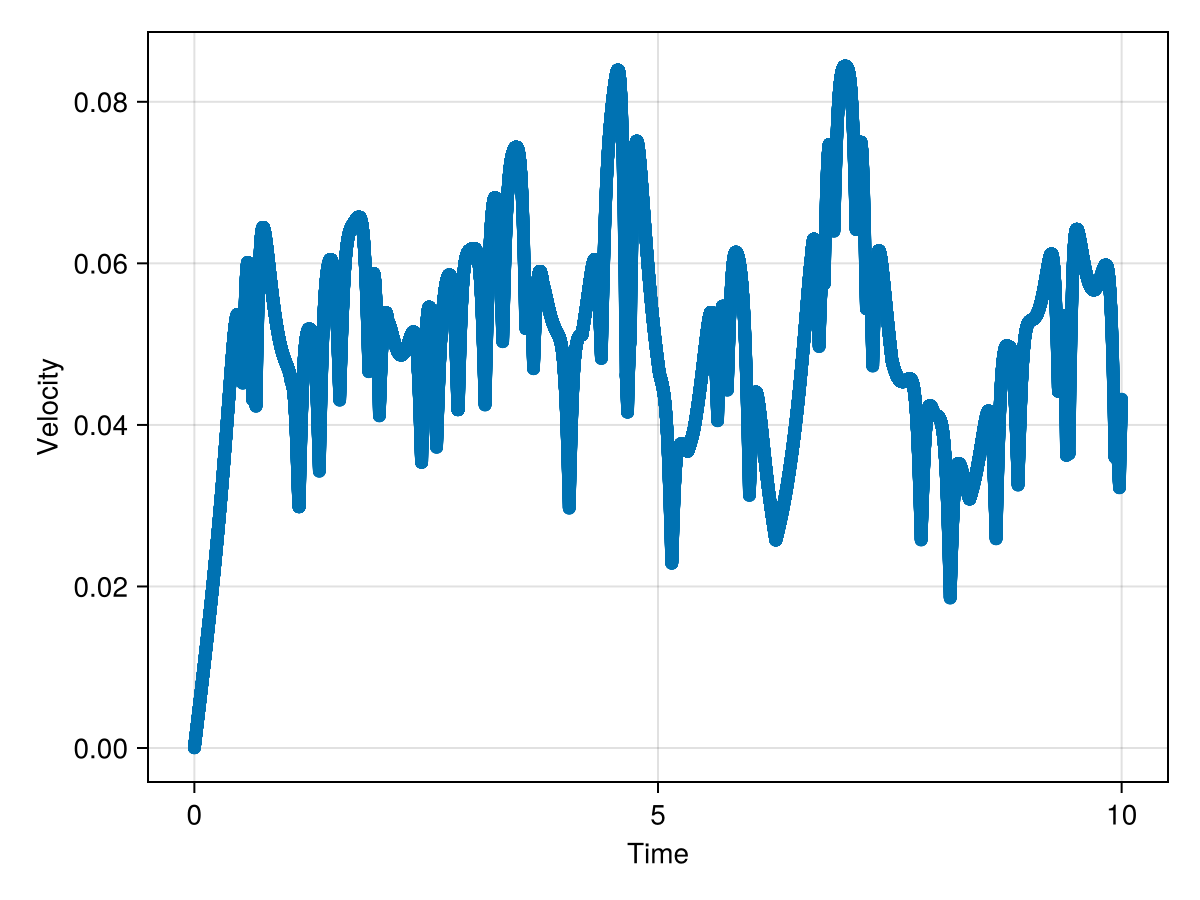

In [9]:
fig = cm.Figure()
ax = cm.Axis(fig[1, 1], xlabel="Time", ylabel="Velocity")
cm.plot!(ax, t, v)

fig

In [10]:
energy = calc_lj_hamiltonian(pos_arr, dt=dt, cutoff=cutoff,L=box_size)
t = collect(range(0,length(energy)*dt,length(energy)));

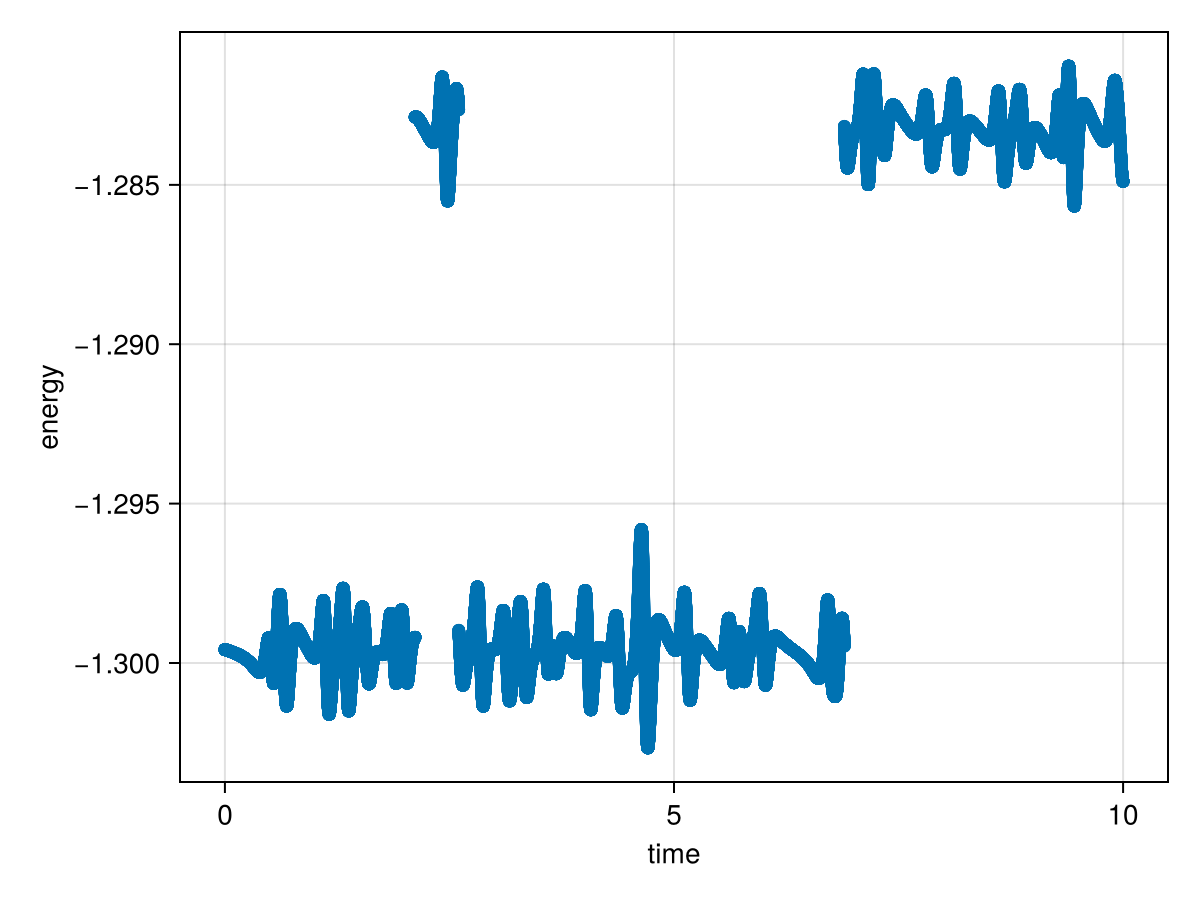

In [11]:
fig = cm.Figure()
ax = cm.Axis(fig[1,1],xlabel="time", ylabel="energy")

cm.plot!(ax, t, energy)


# cm.xlims!(ax, 0, 0.2)
# cm.ylims!(ax, 8000, 8300)


fig